Uso de modelos con el datatset combinado, que tiene fusionados en horizontal todos los csv de las variables financieras preprocesadas.

In [ ]:
import pandas as pd
#from google.colab import drive
import numpy as np
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV,cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout,Conv1D, GlobalMaxPooling1D
from sklearn.metrics import confusion_matrix,roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier,plot_importance
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE,ADASYN,KMeansSMOTE

from sklearn.decomposition import PCA


from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier

from sklearn.impute import SimpleImputer


from tensorflow.keras.callbacks import EarlyStopping
#import shap


In [ ]:

ruta='../../data/'


df_combined = pd.read_csv(ruta+'dfCombinado.csv')



In [ ]:
df_combined

,ID,Endeudamiento2010,Endeudamiento2011,Endeudamiento2012,Endeudamiento2013,Endeudamiento2014,Endeudamiento2015,Endeudamiento2016,Endeudamiento2017,Endeudamiento2018,...,Zombi2018,Zombi2019,Zombi2020,Zombi2021,Zombi2022,Zombi2016-2018,Zombi2017-2019,Zombi2018-2020,Zombi2019-2021,Zombi2020-2022
0,2.331510e+05,0.481564,0.504275,0.528986,0.526416,0.438958,0.421232,0.456693,0.444376,0.437555,...,0,0,0,0,0,0,0,0,0,0
1,2.332070e+05,0.417697,0.438167,0.419161,0.405979,0.415085,0.421306,0.423336,0.417468,0.418792,...,0,0,0,0,0,0,0,0,0,0
2,2.332350e+05,0.390563,0.390563,0.390563,0.386473,0.398405,0.402884,0.392962,0.397971,0.394088,...,0,0,0,0,0,0,0,0,0,0
3,2.332840e+05,0.461182,0.423969,0.422467,0.420274,0.440206,0.471725,0.459850,0.459710,0.455228,...,0,0,0,0,0,0,0,0,0,0
4,2.332910e+05,0.438801,0.420453,0.415624,0.411939,0.418133,0.416285,0.439980,0.437075,0.441119,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12261,2.120828e+10,0.431598,0.431598,0.431598,0.427784,0.437189,0.437174,0.433567,0.390638,0.392090,...,1,0,0,1,0,0,0,0,0,0
12262,2.120849e+10,0.619078,0.619078,0.619078,0.616522,0.614381,0.613338,0.610860,0.610860,0.744588,...,0,0,0,0,0,0,0,0,0,0
12263,2.121003e+10,0.702200,0.702200,0.702200,0.700202,0.692943,0.691444,0.689467,0.689467,0.725373,...,0,0,0,0,0,0,0,0,0,0
12264,2.121895e+10,0.420357,0.420357,0.420357,0.416468,0.426565,0.426611,0.500286,0.440874,0.409549,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
# Preparar los datos para el modelo
feature_columns = [col for col in df_combined.columns if 'Zombi' not in col and "2022" not in col and col != 'ID']
feature_zombis = ['Zombi2010','Zombi2011', 'Zombi2012', 'Zombi2013', 'Zombi2014', 'Zombi2015', 'Zombi2016', 'Zombi2017', 'Zombi2018', 'Zombi2019', 'Zombi2020', 'Zombi2021']

feature_columns = list(set(feature_columns + feature_zombis))
feature_columns.sort()
target_column="Zombi2022"

X= df_combined[feature_columns]
y = df_combined[target_column].values

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Formato adecuado para LSTM: [samples, time steps, features]
# Suponemos que cada año es un paso de tiempo y cada variable un feature
# Reshape M [muestras, pasos de tiempo, características]
#X_train = X_train.reshape((X_train.shape[0], X_train.shape[1] , 1))
#X_test = X_test.reshape((X_test.shape[0], X_test.shape[1] , 1))

# Verificar las dimensiones de los datos transformados
(X_train.shape, X_test.shape)

((9812, 96), (2454, 96))

In [ ]:
# Aplicar Oversampling
adasyn = ADASYN(sampling_strategy='minority', random_state=42, n_neighbors=5) #mejora el recall

smote = SMOTE(random_state=42)


#X_train, y_train = smote.fit_resample(X_train, y_train)
X_train, y_train = adasyn.fit_resample(X_train, y_train)
(X_train.shape, X_test.shape)

((16597, 96), (2454, 96))

In [ ]:
# Calcular el balance de clases para ajustar scale_pos_weight
# Es la relación del número de ejemplos negativos a los positivos
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

model_XGBoost = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=ratio,  # Ajustar según el desequilibrio de clases
    max_depth=6,            # Profundidad del árbol, típicamente entre 3-10
    min_child_weight=1,     # El mínimo de sumas de pesos de instancias necesarias en un hijo
    gamma=0.3,              # Reducción mínima de la pérdida necesaria para hacer una división
    subsample=0.8,          # Fracción de muestras para entrenar cada árbol
    colsample_bytree=0.8,   # Fracción de características para entrenar cada árbol
    n_estimators=200,       # Número de árboles
    learning_rate=0.1       # Tasa de aprendizaje
)
model_XGBoost.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.3, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
# Definir el modelo y los parámetros para la búsqueda en cuadrícula
model_RF = RandomForestClassifier(


    max_depth=6,            # Profundidad del árbol, típicamente entre 3-10
    n_estimators=200,       # Número de árboles

)
model_RF.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, n_estimators=200)

In [ ]:

model_LTSM = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_LTSM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model_LTSM.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,  # Usando el 20% de los datos de entrenamiento para validación
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)


Epoch 1/20
415/415 [==============================] - 12s 22ms/step - loss: 0.5975 - accuracy: 0.6886 - val_loss: 0.8478 - val_accuracy: 0.5136
Epoch 2/20
415/415 [==============================] - 9s 21ms/step - loss: 0.5635 - accuracy: 0.7243 - val_loss: 0.7737 - val_accuracy: 0.5130
Epoch 3/20
415/415 [==============================] - 8s 19ms/step - loss: 0.5583 - accuracy: 0.7273 - val_loss: 0.9392 - val_accuracy: 0.3467
Epoch 4/20
415/415 [==============================] - 7s 17ms/step - loss: 0.5567 - accuracy: 0.7317 - val_loss: 0.8396 - val_accuracy: 0.4488
Epoch 5/20
415/415 [==============================] - 8s 20ms/step - loss: 0.5560 - accuracy: 0.7314 - val_loss: 0.9136 - val_accuracy: 0.4328
Epoch 6/20
415/415 [==============================] - 7s 18ms/step - loss: 0.5562 - accuracy: 0.7340 - val_loss: 0.8757 - val_accuracy: 0.4166
Epoch 7/20
415/415 [==============================] - 7s 18ms/step - loss: 0.5551 - accuracy: 0.7352 - val_loss: 0.8890 - val_accuracy: 0.436

In [ ]:


model_CNN = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_CNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model_CNN.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/10
415/415 [==============================] - 5s 8ms/step - loss: 0.6154 - accuracy: 0.6553 - val_loss: 1.0141 - val_accuracy: 0.2169
Epoch 2/10
415/415 [==============================] - 3s 7ms/step - loss: 0.5812 - accuracy: 0.6861 - val_loss: 0.8196 - val_accuracy: 0.5482
Epoch 3/10
415/415 [==============================] - 3s 8ms/step - loss: 0.5788 - accuracy: 0.6855 - val_loss: 0.9927 - val_accuracy: 0.2633
Epoch 4/10
415/415 [==============================] - 3s 6ms/step - loss: 0.5775 - accuracy: 0.6846 - val_loss: 1.0017 - val_accuracy: 0.2611
Epoch 5/10
415/415 [==============================] - 3s 6ms/step - loss: 0.5767 - accuracy: 0.6889 - val_loss: 0.9118 - val_accuracy: 0.2687
Epoch 6/10
415/415 [==============================] - 3s 8ms/step - loss: 0.5763 - accuracy: 0.6875 - val_loss: 0.8924 - val_accuracy: 0.2699
Epoch 7/10
415/415 [==============================] - 3s 8ms/step - loss: 0.5757 - accuracy: 0.6883 - val_loss: 0.9557 - val_accuracy: 0.2669
Epoch 

In [ ]:
# Creación de un DataFrame para almacenar las métricas
df_metricas = pd.DataFrame(index=["XGBoost","RF", "LTSM","CNN"])

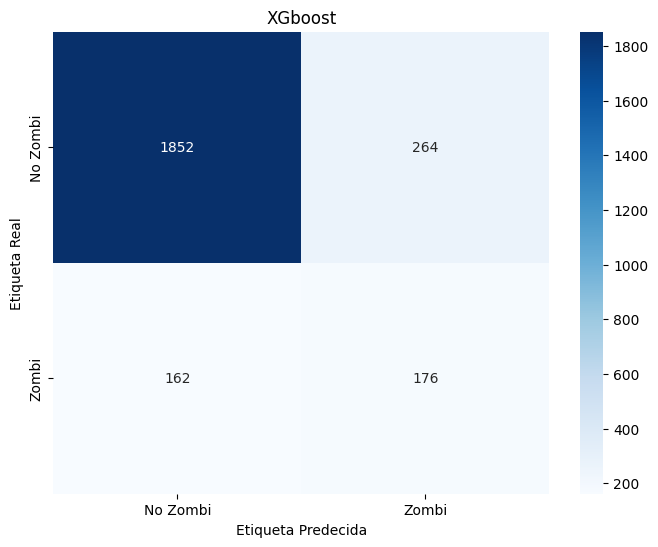

In [ ]:
# Predecir las etiquetas para el conjunto de testeo
y_pred = model_XGBoost.predict(X_test)


df_metricas.loc["XGBoost", "Accuracy"] =  accuracy_score(y_test, y_pred)

df_metricas.loc["XGBoost", "Precision"] = precision_score(y_test, y_pred)
df_metricas.loc["XGBoost", "Recall"] = recall_score(y_test, y_pred)
df_metricas.loc["XGBoost", "F1 Score"] = f1_score(y_test,y_pred)




# Calcular la matriz de confusión TEST
conf_matrix = confusion_matrix(y_test, y_pred)


# Nombres de las clases para el heatmap
class_names = ['No Zombi', 'Zombi']

# Crear el heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Añadir títulos y etiquetas para claridad
plt.title('XGboost')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predecida')

# Mostrar la visualización
plt.show()

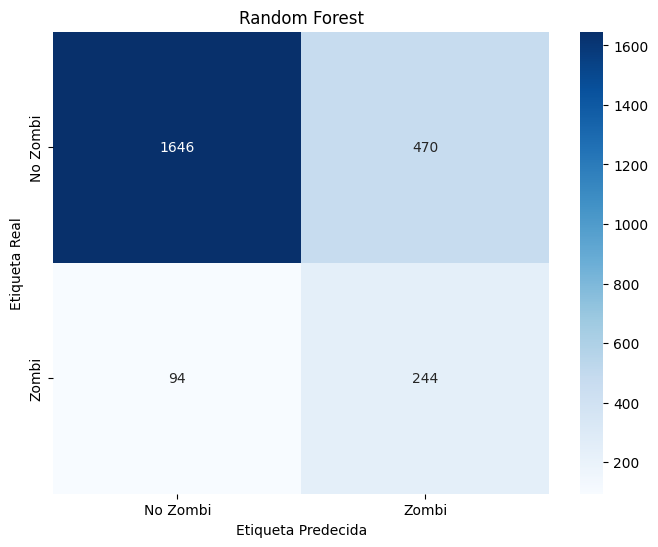

In [ ]:
# Predecir las etiquetas para el conjunto de testeo
y_pred = model_RF.predict(X_test)

df_metricas.loc["RF", "Accuracy"] =  accuracy_score(y_test, y_pred)

df_metricas.loc["RF", "Precision"] = precision_score(y_test, y_pred)
df_metricas.loc["RF", "Recall"] = recall_score(y_test, y_pred)
df_metricas.loc["RF", "F1 Score"] = f1_score(y_test,y_pred)

# Calcular la matriz de confusión TEST
conf_matrix = confusion_matrix(y_test, y_pred)


# Nombres de las clases para el heatmap
class_names = ['No Zombi', 'Zombi']

# Crear el heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Añadir títulos y etiquetas para claridad
plt.title('Random Forest')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predecida')

# Mostrar la visualización
plt.show()

77/77 [==============================] - 1s 9ms/step


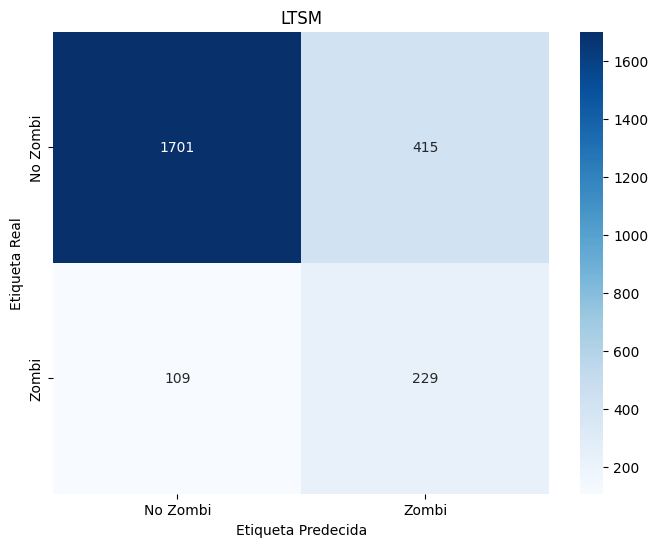

In [ ]:
# Predecir las etiquetas para el conjunto de testeo

y_pred_probs = model_LTSM.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

df_metricas.loc["LTSM", "Accuracy"] =  accuracy_score(y_test, y_pred)
#df_metricas.loc["LTSM", "Balanced Accuracy"] = balanced_accuracy(y_test, y_pred)
df_metricas.loc["LTSM", "Precision"] = precision_score(y_test, y_pred)
df_metricas.loc["LTSM", "Recall"] = recall_score(y_test, y_pred)
df_metricas.loc["LTSM", "F1 Score"] = f1_score(y_test,y_pred)
# Calcular la matriz de confusión TEST
conf_matrix = confusion_matrix(y_test, y_pred)


# Nombres de las clases para el heatmap
class_names = ['No Zombi', 'Zombi']

# Crear el heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Añadir títulos y etiquetas para claridad
plt.title('LTSM')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predecida')

# Mostrar la visualización
plt.show()

77/77 [==============================] - 0s 5ms/step
Confusion Matrix:
 [[1701  415]
 [ 109  229]]


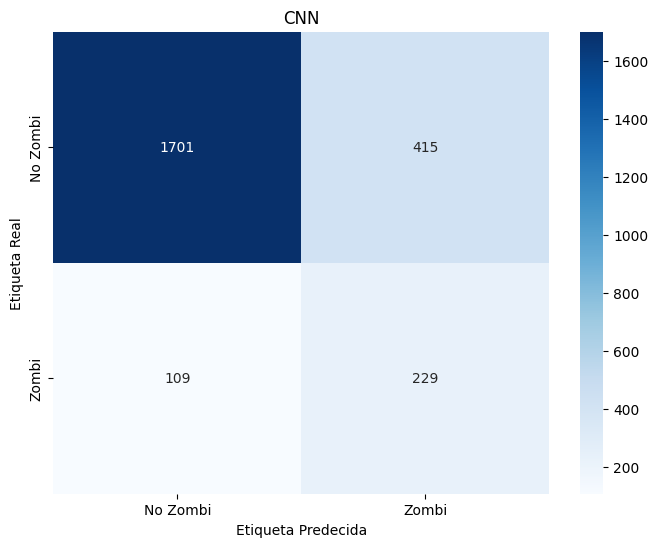

In [ ]:
# Predecir las etiquetas para el conjunto de testeo
y_pred = model_CNN.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

df_metricas.loc["CNN", "Accuracy"] =  accuracy_score(y_test, y_pred)
df_metricas.loc["CNN", "F1 Score"] = f1_score(y_test, y_pred)
df_metricas.loc["CNN", "Precision"] = precision_score(y_test, y_pred)
df_metricas.loc["CNN", "Recall"] = recall_score(y_test, y_pred)

# Calcular la matriz de confusión TEST
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Nombres de las clases para el heatmap
class_names = ['No Zombi', 'Zombi']

# Crear el heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Añadir títulos y etiquetas para claridad
plt.title('CNN')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predecida')

# Mostrar la visualización
plt.show()

In [ ]:
df_metricas

,Accuracy,Precision,Recall,F1 Score
XGBoost,0.826406,0.400000,0.520710,0.452442
RF,0.770171,0.341737,0.721893,0.463878
LTSM,0.786471,0.355590,0.677515,0.466395
CNN,0.786471,0.355590,0.677515,0.466395
